# Dataset B
## Madison Chester, Adriana Álvaro, Dafni Tziakouri


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
datadir = '/content/gdrive/MyDrive/Kaggle Competition/fakeseverywhere'

# Dataset B

In [3]:
# !pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
train_B = pd.read_csv(os.path.join(datadir, 'train_B_text.csv'))
test_B = pd.read_csv(os.path.join(datadir, 'test_B_text.csv'))

In [5]:
print('Train B Samples: ', len(train_B))
print('Test B Samples: ', len(test_B))

Train B Samples:  3497
Test B Samples:  1500


In [6]:
print(train_B['Fake/Real'].value_counts(normalize=True))

real    0.800114
fake    0.199886
Name: Fake/Real, dtype: float64


In [7]:
train_B

,Id,Title,Fake/Real
0,0,"""Humanitarian Aid: Volunteers Bring Relief to ...",fake
1,1,"Vegan, Low-Carbohydrate Eco-Atkins Diet could ...",real
2,2,"Fannie, Freddie Score Win Against Conn. Cities...",real
3,3,'Bachelorette' star Andi Dorfman quits job as ...,real
4,4,Deconstructing the FCC's Net Neutrality Ruling,real
...,...,...,...
3492,3492,WhatsApp CEO: Facebook will not affect privacy...,real
3493,3493,"""Marine Wonders: Coral Reefs Teeming with Exot...",fake
3494,3494,"""Space Exploration Milestone: Astronauts Embar...",fake
3495,3495,Teva Pharmaceutical Industries Ltd (ADR) Recei...,real


In [8]:
test_B

,Id,Title
0,0,Roche's cobas HPV Test gets FDA approval for f...
1,1,Security on High Alert at Final Four Events
2,2,Computer simulation shows how our universe gre...
3,3,DREW BARRYMORE Welcomes Second Daughter Frankie
4,4,Time Warner and Comcast FCC filing hints at ne...
...,...,...
1495,1495,European recovery set to boost emerging markets
1496,1496,The Hanson Brothers Are All Grown Up and Have ...
1497,1497,Moto E Makes an Appearance via Leaked Image; F...
1498,1498,Buried Fossil Soils Found To Be Rich In Carbon


# Feature extraction and word2vec model training for preprocessing

<ipython-input-9-eaadc592f763>:41: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X_copy.corr()


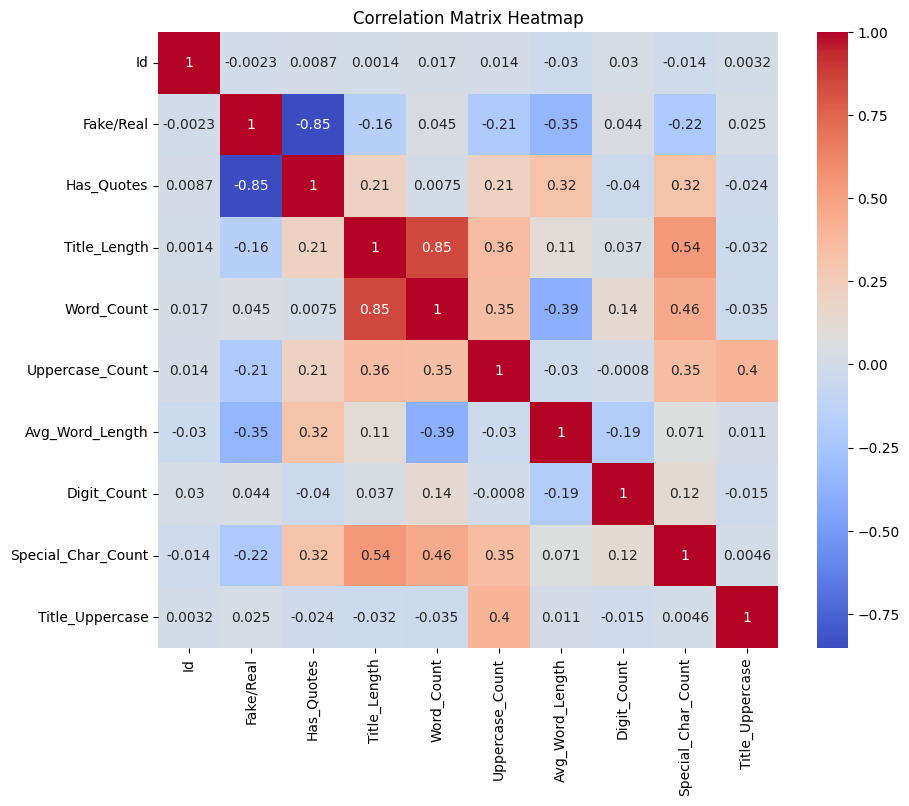

(2622, 300)
(2622, 11)


,Has_Quotes,Title_Length,Word_Count,Uppercase_Count,Avg_Word_Length,Digit_Count,Special_Char_Count,Title_Uppercase,0,1,...,290,291,292,293,294,295,296,297,298,299
0,-0.466123,-1.157555,-1.193239,-1.050389,0.290884,3.689133,-1.085091,-0.051738,0.042354,0.06616,...,0.034161,0.086777,0.017197,-0.010982,0.082913,0.095678,-0.006751,-0.080655,0.030613,-0.039549
1,-0.466123,0.535708,2.223171,1.585591,-2.00635,0.250244,-0.025855,-0.051738,0.057169,0.083518,...,0.045388,0.116833,0.022384,-0.009313,0.111792,0.127646,-0.008282,-0.106,0.036079,-0.050848
2,-0.466123,-0.245798,-0.813638,-1.290023,1.284657,-0.437534,-1.085091,-0.051738,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.466123,1.186963,1.84357,-0.331485,-1.003333,-0.437534,0.503763,-0.051738,0.056465,0.085409,...,0.045799,0.1182,0.020523,-0.010446,0.112902,0.129304,-0.008275,-0.108123,0.037242,-0.052828
4,2.145359,0.210081,-0.813638,0.147784,2.255319,-0.437534,-0.025855,-0.051738,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617,-0.466123,1.38234,1.463969,1.106322,-0.443335,0.938022,2.622235,-0.051738,0.048841,0.070098,...,0.036454,0.098888,0.01706,-0.008331,0.093182,0.106707,-0.006592,-0.090202,0.033269,-0.044145
2618,-0.466123,0.210081,0.704767,-0.331485,-0.87097,3.001355,0.503763,-0.051738,0.046195,0.066825,...,0.034583,0.09195,0.017981,-0.008558,0.087875,0.102894,-0.006895,-0.084104,0.029312,-0.040843
2619,-0.466123,0.535708,0.325166,0.627053,0.161462,-0.437534,1.562999,-0.051738,0.058682,0.085999,...,0.045608,0.119923,0.023106,-0.010436,0.114984,0.131668,-0.007772,-0.109264,0.038212,-0.053578
2620,-0.466123,-0.897053,-0.813638,-0.810754,-0.102003,-0.437534,-1.085091,-0.051738,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Define the extract_features function
def extract_features(df):
    # Feature 1: Presence of Quotes
    df['Has_Quotes'] = df['Title'].str.contains('"').astype(int)

    # Feature 2: Title Length
    df['Title_Length'] = df['Title'].apply(len)

    # Feature 3: Number of Words
    df['Word_Count'] = df['Title'].str.split().apply(len)

    # Feature 4: Number of Uppercase Characters
    df['Uppercase_Count'] = df['Title'].apply(lambda x: sum(1 for c in x if c.isupper()))

    # Feature 5: Average Word Length
    df['Avg_Word_Length'] = df['Title'].str.split().apply(lambda x: sum(len(word) for word in x) / len(x))

    # Feature 6: Number of Digits
    df['Digit_Count'] = df['Title'].apply(lambda x: sum(1 for c in x if c.isdigit()))

    # Feature 7: Number of Special Characters
    special_characters = r'[^A-Za-z0-9 ]'
    df['Special_Char_Count'] = df['Title'].str.count(special_characters)

    # Feature 8: Title in Uppercase
    df['Title_Uppercase'] = df['Title'].apply(lambda x: x.isupper()).astype(int)

    return df

# Extract features from the training data
X_train = extract_features(train_B) # X_train is a df here

# We do the split before learning the standarization
# Stratified by 'Fake/Real' labels
label_encoding = {'fake': 0, 'real': 1}
y = train_B['Fake/Real'].map(label_encoding) # y is a pandas series

# Creating a correlation matrix
X_copy = X_train
X_copy['Fake/Real'] =  X_copy['Fake/Real'].map(label_encoding)
correlation_matrix = X_copy.corr()
# Set the size of the heatmap
plt.figure(figsize=(10, 8))
# Generate the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# Set title
plt.title('Correlation Matrix Heatmap')
# Display the plot
plt.show()

X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.25, random_state=42, stratify=y)

# Normalize extracted features
# Initialize the StandardScaler for the columns you want to scale
scaler = StandardScaler()

# List of columns to be scaled (all columns except 'Id', 'Title' and 'Fake/Real')
columns_to_scale = [col for col in X_train.columns if col not in ['Id', 'Title', 'Fake/Real']]

# Create a ColumnTransformer to specify which columns to transform
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', scaler, columns_to_scale)
    ],
    remainder='passthrough'  # Include the 'Title' and 'Fake/Real' columns without scaling
)

# Fit and transform X_train. Apply that preprocessing to X_val and X_test
X_train_normalized = preprocessor.fit_transform(X_train[columns_to_scale])
X_train[columns_to_scale] = X_train_normalized
X_val[columns_to_scale] = preprocessor.transform(X_val[columns_to_scale])

# Tokenization and stop-word removal
stop_words = set(stopwords.words("english"))

# Train the Word2Vec model on the training data
X = X_train['Title']
X = X.apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

# Train Word2Vec model with the training set
word2vec_model = Word2Vec(sentences=X, vector_size=300, window=17, min_count=9, sg=1)

# Create document vectors by averaging word vectors
def get_doc_vector(words):
    valid_words = [word for word in words if word in word2vec_model.wv.key_to_index]
    if valid_words:
        return np.mean(word2vec_model.wv[valid_words], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Apply the word vectorizer to the text on Title
X_w2v_train = X_train['Title'].apply(get_doc_vector)
X_w2v_train = np.vstack(X_w2v_train)
X_w2v_train = pd.DataFrame(data=X_w2v_train)
print(X_w2v_train.shape)
print(X_train.shape)

# Concatenate arrays column-wise of the normalized extracted features and the vectorized title
combined_array = np.concatenate((X_train.values, X_w2v_train.values), axis=1)

# Create a new DataFrame from the concatenated array
columns = list(X_train.columns) + list(X_w2v_train.columns)
X_train = pd.DataFrame(combined_array, columns=columns)
X_train = X_train.drop(columns=['Id', 'Title', 'Fake/Real'])
X_train.columns = X_train.columns.astype(str)

X_train

# Defining Function to Plot the ROC

In [10]:
def plot_roc_curve(y_true, y_scores, model_name=''):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_scores):.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

    # Find the threshold closest to the top-left corner (ideal point)
    top_left_idx = np.argmax(tpr - fpr)
    threshold = thresholds[top_left_idx]

    # Inside your plot_roc_curve function, after plotting the ideal point:
    plt.plot(fpr[top_left_idx], tpr[top_left_idx], 'ro', markersize=8)

    # Adding label with threshold value
    plt.text(fpr[top_left_idx], tpr[top_left_idx], f'Threshold: {threshold:.2f}', verticalalignment='bottom', horizontalalignment='right')
    plt.show()

# Training and evaluation the model

In [ ]:
# Define the class weights
class_weights = [{1: 1, 0: w} for w in [2, 3, 4]]  # Example weights for class 1 and various weights for class 0 (fake)

# Create the parameter grid with class weights
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': class_weights  # Include class weights in the parameter grid
}

# Create the GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the data
grid_search.fit(X_train.values, y_train.values)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best parameters to train the final model
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

model = best_model

# NEED TO APPLY THE WORD2VEC MODEL IN THE XVAL
# apply the word vectorizer to the text on Title
X_w2v_val = X_val['Title'].apply(get_doc_vector)
X_w2v_val = np.vstack(X_w2v_val)
X_w2v_val = pd.DataFrame(data=X_w2v_val)
print(X_w2v_val.shape)
print(X_val.shape)

# Convert DataFrames to arrays
X_val_array = X_val.values
X_w2v_val_array = X_w2v_val.values

# Concatenate arrays column-wise
combined_val_array = np.concatenate((X_val_array, X_w2v_val_array), axis=1)

# Create a new DataFrame from the concatenated array
columns = list(X_val.columns) + list(X_w2v_val.columns)
X_val = pd.DataFrame(combined_val_array, columns=columns)
X_val = X_val.drop(columns=['Id', 'Title', 'Fake/Real'])
X_val.columns = X_val.columns.astype(str)


# Predict on the validation set
y_pred_val_B = model.predict(X_val)

# Calculate and print accuracy on the validation set
accuracy = accuracy_score(y_val, y_pred_val_B)
print("Accuracy on validation set:", accuracy)

classification_rep = classification_report(y_val, y_pred_val_B)
print("Classification Report:\n", classification_rep)

# Plot the ROC
y_scores_val_B = model.predict_proba(X_val)[:, 1]  # Get the probability estimates for class 1 (Real)
plot_roc_curve(y_val, y_scores_val_B, model_name=model)

In [ ]:
# Plot the ROC from the model directly
y_scores_val_B = model.predict_proba(X_val.values)[:, 1]  # Get the probability estimates for class 1 (Real)

# To change the operating point to a specific threshold
list_thresholds = [0.5, 0.59]
for new_threshold in list_thresholds:
  plot_roc_curve(y_val, y_scores_val_B, model_name=model)

  new_pred_labels = (y_scores_val_B > new_threshold).astype(int)
  print(classification_report(y_val, new_pred_labels))

In [13]:
# Define model parameters
params = {
    'max_depth': 10,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 100,
    'class_weight': {1: 1, 0: 4} # 1 is the real class, 0 is the fake class
}

# Train the RandomForest classifier on the training data
model = RandomForestClassifier(random_state=42, **params)
model.fit(X_train.values, y_train.values)

# NEED TO APPLY THE WORD2VEC MODEL IN THE XVAL
# the feature extraction and standarization has already been done
# Just need to apply the word vectorizer to the text on Title
X_w2v_val = X_val['Title'].apply(get_doc_vector)
X_w2v_val = np.vstack(X_w2v_val)
X_w2v_val = pd.DataFrame(data=X_w2v_val)
print(X_w2v_val.shape)
print(X_val.shape)

# Concatenate arrays column-wise
combined_val_array = np.concatenate((X_val.values, X_w2v_val.values), axis=1)

# Create a new DataFrame from the concatenated array
columns = list(X_val.columns) + list(X_w2v_val.columns)
X_val = pd.DataFrame(combined_val_array, columns=columns)
X_val = X_val.drop(columns=['Id', 'Title', 'Fake/Real'])
X_val.columns = X_val.columns.astype(str)

# Predict on the validation set
y_pred_val_B = model.predict(X_val.values)

# Calculate and print accuracy on the validation set
accuracy = accuracy_score(y_val.values, y_pred_val_B)
print("Accuracy on validation set:", accuracy)

classification_rep = classification_report(y_val.values, y_pred_val_B)
print("Classification Report:\n", classification_rep)

(875, 300)
(875, 11)
Accuracy on validation set: 0.9474285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86       175
           1       0.96      0.98      0.97       700

    accuracy                           0.95       875
   macro avg       0.93      0.90      0.91       875
weighted avg       0.95      0.95      0.95       875



# Testing the model

In [14]:
# Retrain the model on all the data available
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = np.concatenate((y_train, y_val))
model = RandomForestClassifier(random_state=42, **params)
model.fit(X_combined.values, y_combined) # X_combined is a df so we use the .values()

RandomForestClassifier(class_weight={0: 4, 1: 1}, max_depth=10,
                       min_samples_split=10, random_state=42)

In [15]:
# Extract features from the test data and apply the same preprocessing
X_test = extract_features(test_B)

# List of columns to be scaled (all columns except 'Id', 'Title')
columns_to_scale = [col for col in X_test.columns if col not in ['Id', 'Title']]
X_test[columns_to_scale] = preprocessor.transform(X_test[columns_to_scale])

X_test['Title'] = X_test['Title'].apply(lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words])

# Create Word2Vec vectors for the test data
X_w2v_test = X_test['Title'].apply(get_doc_vector)
X_w2v_test = np.vstack(X_w2v_test)

# Concatenate extracted features with Word2Vec vectors for the test data
X_test = X_test.drop(['Id','Title'], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(X_w2v_test)], axis=1)

# Convert feature names to strings for X_test_B
X_test.columns = X_test.columns.astype(str) # Here X_test is a df

# Make predictions on the test data
y_pred_test_B = model.predict(X_test.values)

# Changing the predictions according to the optimal threshold
y_scores_test_B = model.predict_proba(X_test)[:, 1]

new_threshold = 0.59 # REPLACE WITH THE DESIRED THRESHOLD

y_pred_test_B = (y_scores_test_B > new_threshold).astype(int)

# Now, 'y_pred_test_B' contains the predictions for the test data
y_pred_test_B

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1])

# Save/Read a model

In [16]:
# save the model
from datetime import date
import pickle
import uuid

classifier = 'rf'
date = str(date.today())
acc = str(accuracy)[:6]
id = str(uuid.uuid4())
model_name = '_'.join([classifier, date, acc, id]) +  '.pickle'

with open('/content/gdrive/MyDrive/Kaggle Competition/models_B/' + model_name, 'wb') as f:
  pickle.dump(model, f)

In [17]:
# read a model

# import pickle
# model_name = ''
# with open('/content/gdrive/MyDrive/Kaggle Competition/models_B/' + model_name, 'rb') as f:
#   model = pickle.load(f)

# Prepare the csv with the predictions for submission

In [18]:
y_pred_test_B_df = pd.DataFrame()
reverse_label_encoding = {0: 'fake', 1: 'real'}

y_pred_test_B_df['Prediction'] = y_pred_test_B
y_pred_test_B_df['Prediction'] = y_pred_test_B_df['Prediction'].map(reverse_label_encoding)
y_pred_test_B_df['Id'] = np.array(y_pred_test_B_df.index)
y_pred_test_B_df = y_pred_test_B_df[['Id', 'Prediction']]

file_path = os.path.join('/content/gdrive/MyDrive/Kaggle Competition', 'y_pred_test_B.csv')

y_pred_test_B_df.to_csv(file_path, index=False)
y_pred_test_B_df = pd.read_csv(file_path)

y_pred_test_B_df

,Id,Prediction
0,0,real
1,1,real
2,2,real
3,3,fake
4,4,real
...,...,...
1495,1495,real
1496,1496,real
1497,1497,real
1498,1498,real


In [19]:
# read the prediction for test_A
file_path = '/content/gdrive/MyDrive/Kaggle Competition/y_pred_test_A.csv'
y_pred_test_A_df = pd.read_csv(file_path)

y_pred_test_A_df

,Id,Prediction
0,0,fake
1,1,real
2,2,fake
3,3,fake
4,4,real
...,...,...
251,251,fake
252,252,real
253,253,real
254,254,real


In [20]:
# concatenate both predictions
y_pred= pd.DataFrame()

y_pred = pd.concat([y_pred_test_A_df, y_pred_test_B_df], ignore_index=True)
y_pred['Id'] = y_pred.index
y_pred

,Id,Prediction
0,0,fake
1,1,real
2,2,fake
3,3,fake
4,4,real
...,...,...
1751,1751,real
1752,1752,real
1753,1753,real
1754,1754,real


In [21]:
# save the concatenated predictions
file_path = os.path.join('/content/gdrive/MyDrive/Kaggle Competition', 'y_pred.csv')
y_pred.to_csv(file_path, index=False)
y_pred = pd.read_csv(file_path)
y_pred

,Id,Prediction
0,0,fake
1,1,real
2,2,fake
3,3,fake
4,4,real
...,...,...
1751,1751,real
1752,1752,real
1753,1753,real
1754,1754,real


In [22]:
y_pred['Prediction'] = np.nan
y_pred.loc[256:, 'Prediction'] = y_pred_test_B_df['Prediction'].values
y_pred

,Id,Prediction
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
...,...,...
1751,1751,real
1752,1752,real
1753,1753,real
1754,1754,real


In [23]:
file_path = os.path.join('/content/gdrive/MyDrive/Kaggle Competition', 'y_pred_prueba_B.csv')
y_pred.to_csv(file_path, index=False)